# San Diego Food Insecurity + Spatial Clustering
 Featuring Blobs, a project of Urban CCD in Chicago: https://github.com/ChicagoHarris/blobs






## Preparing Spatial Data

In [1]:
# Import required libraries and assign root directory of blobs to root
import blobs
import numpy as np
import pandas as pd
import pysal as ps
import os

pd.options.mode.chained_assignment = None 
root = os.getcwd()
%pylab inline
SHAPE_FILE = root + '/CENSUS_TRACTS_2010/CENSUS_TRACTS_2010.shp'
DBF_FILE = root + '/CENSUS_TRACTS_2010/CENSUS_TRACTS_2010.dbf'

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Open census tract shapefile and database.
shp_link = SHAPE_FILE
dbf = ps.open(DBF_FILE)

In [3]:
# Shapefile and data preparation.
cols = np.array([dbf.by_col(col) for col in dbf.header]).T
df_tracts = pd.DataFrame(cols)
df_tracts.columns = dbf.header
df_tracts['order'] = df_tracts.index

In [4]:
df_tracts.head()

,TRACT,SHAPE_AREA,SHAPE_LEN,order
0,15,8693887.01877,12443.272111,0
1,16,7407379.04537,11329.616060,1
2,17,6714939.68453,10791.678584,2
3,18,8036707.98019,13929.689427,3
4,19,17966650.12860,21026.710682,4


In [5]:
# Run this to create a weight file for a custom set of shapefiles for use in blobs
rook_w = ps.rook_from_shapefile(shp_link, idVariable="TRACT")
gal = ps.open('CENSUS_TRACTS_2010/CENSUS_TRACTS_2010.gal','w')
rook_w.n
gal.write(rook_w)
gal.close()

In [6]:
# Assign spatial weight for census tracts.
w=ps.open(root + '/CENSUS_TRACTS_2010/CENSUS_TRACTS_2010.gal').read()

## Preparing Food Insecurity Data

In [7]:
#the file I downloaded from http://data.sandiegodata.org/dataset/san-diego-census-tracts, then dropped the airport tract
sd_data = pd.read_csv('sandiegocensustract.csv', index_col=0)

In [8]:
sd_data.columns

Index([u'TRACTNUM', u'TRACT', u'SevCrwd', u'TeenBirthProportion', u'TeenBirthAllWom', u'SingMother', u'MaltrtAllegRate', u'FosterCareEntry', u'TotalPov', u'ChildPov', u'ProxOffAlco', u'ProxOnAlco', u'HghSchOrHigh', u'TraffInjur', u'SNAP_FdStmp', u'PovertyRt', u'VoterPartic', u'TotalPopulation', u'ZIP', u'City', u'Longitude', u'Latitude', u'CES20Score', u'CES20PercentileRange', u'PollutionBurdenScore', u'PollutionBurdenPctl', u'LowBirthWeight', u'LowBirthWeightPctl', u'Education', u'EducationPctl', u'Poverty', u'PovertyPctl', u'Unemployment', u'UnemploymentPctl', u'PopCharScore', u'PopCharPctl', u'NeighborhoodName', u'n_FoodDesert', u'pct_FoodDesert', u'LiqCount', u'Uninsured'], dtype='object')

In [9]:
#Keep only food-insecurity related fields
sd_food_data = sd_data[[u'TRACT', u'SingMother', u'SNAP_FdStmp', u'PovertyRt', u'TotalPopulation', u'Unemployment', u'pct_FoodDesert', u'Uninsured']]
sd_food_data['Need'] = 100 * sd_food_data['SNAP_FdStmp'] * sd_food_data['pct_FoodDesert']
sd_food_data.head()

,TRACT,SingMother,SNAP_FdStmp,PovertyRt,TotalPopulation,Unemployment,pct_FoodDesert,Uninsured,Need
0,50.00,0.141199,0.218569,0.424,2227,NaN,0.210393,0.226247,4.598524
1,200.28,0.221421,0.205973,0.370,3479,4.31,0.700034,0.190999,14.418827
2,45.01,0.048000,0.083200,0.151,2875,5.66,0.000000,0.144167,0.000000
3,48.00,0.198259,0.133462,0.428,4115,10.62,0.000000,0.137367,0.000000
4,36.01,0.317631,0.133244,0.469,3250,17.84,0.355928,0.136549,4.742516


In [10]:
# Format data and merge on shapefile IDs
food_shapes = pd.merge(sd_food_data, df_tracts, how='right', left_on='TRACT', 
    right_on='TRACT', sort=False).fillna(0).sort(['order'])

food_shapes = food_shapes.drop(['SHAPE_AREA', 'SHAPE_LEN', 'order'],1)

class bd:
  data = food_shapes
  w = w
  shp_link = shp_link
  id = 'TRACT'
  level = 'tract'

In [11]:
# Assign the attribute data.
d = bd()

## Creating Blobs
You can assign what attribute you would like to "blob" accordingly. In example 1, blobs are created from census tracts and must have a minimum of 10,000 persons per blob.

In [12]:
#suppress shapefile warnings
import warnings
warnings.filterwarnings('ignore')

['SingMother', 'SNAP_FdStmp', 'PovertyRt', 'TotalPopulation', 'Unemployment', 'pct_FoodDesert', 'Uninsured', 'Need']

### CREATING BLOBS FROM 8 VARIABLES ###
    PARAMETERS:
     # Minimum TotalPopulation in each blob: 10000
     # Iterations: 5
     # Method: equal votes
     # Plot blobs: True
     # Save blobs data: False


# ITERATION 1                 
  Score: 1624.05
  Created 212 blobs (2 tracts per blob)
  Best solution so far: 1624.05
  Time taken: 4.8 seconds (19 seconds remaining)


# ITERATION 2                 
  Score: 1392.65
  Created 210 blobs (2 tracts per blob)
  Best solution so far: 1392.65
  Time taken: 5.6 seconds (15 seconds remaining)


# ITERATION 3                 
  Score: 1590.98
  Created 207 blobs (3 tracts per blob)
  Best solution so far: 1392.65
  Time taken: 4.5 seconds (9 seconds remaining)


# ITERATION 4                 
  Score: 1505.65
  Created 214 blobs (2 tracts per blob)
  Best solution so far: 1392.65
  Time taken: 5.1 seconds (5 seconds re

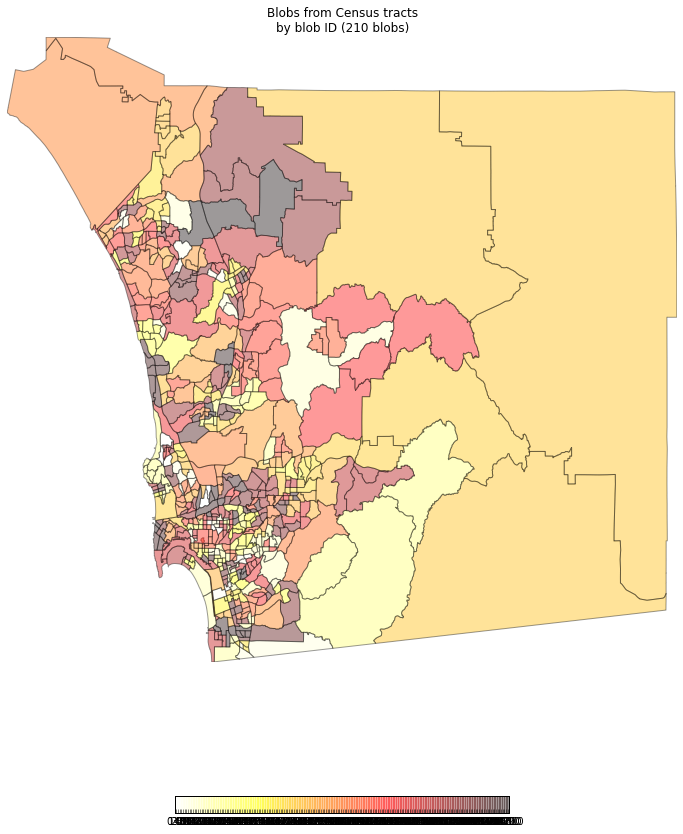

In [13]:
# Example 1: Create blobs minimum population of 10,000 in each blob.
b = blobs.Blobs(d, 'TotalPopulation', 10000, iterations=5)

In [14]:
#how many tracts appear in each blob?
print b.blobs_data['Number of Regions'].min(), b.blobs_data['Number of Regions'].mean(), b.blobs_data['Number of Regions'].max()

2.0 2.98571428571 7.0


  Plotting...
SHAPEFILE WARNING: Polygon 175 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 176 topology has been fixed. (ccw -> cw)


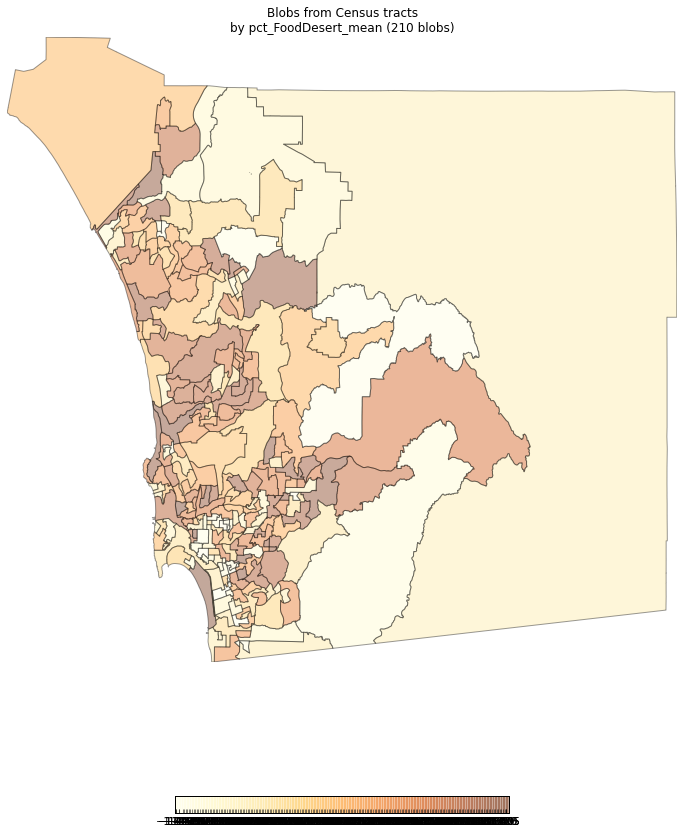

In [17]:
#Visualize the blobs map by Food Desert rate
b.plot_blobs(blob_shp = 'blob_test_1.shp', variable='pct_FoodDesert', cmap='YlOrBr')

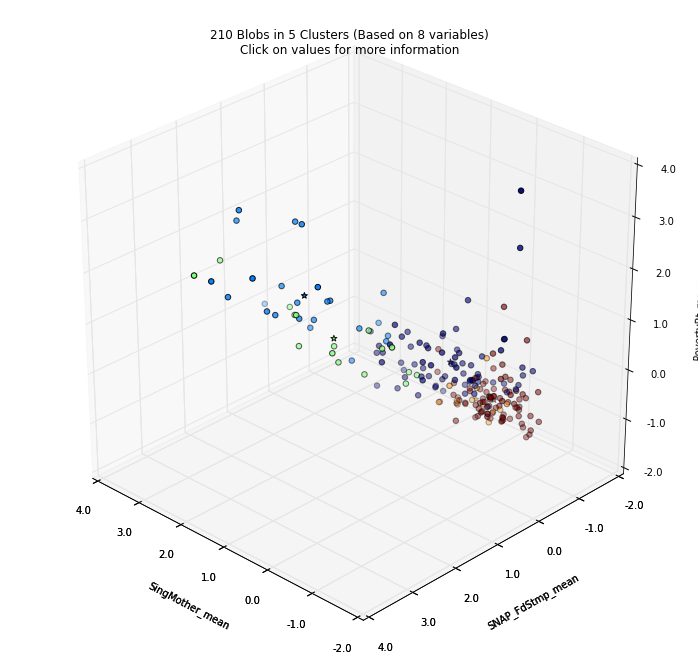

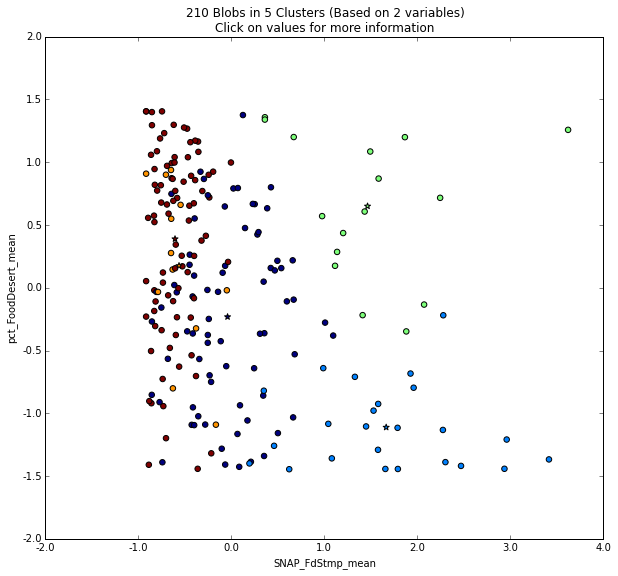

In [56]:
# Cluster the blobs along similarities in the data
cl = blobs.Cluster_blobs(b, blobs_per_cluster=40)
cl.plot(['SNAP_FdStmp_mean', 'pct_FoodDesert_mean']) 

In [ ]:
# See the cluster assignment for each blob
cl.assignments

SHAPEFILE WARNING: Polygon 175 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 176 topology has been fixed. (ccw -> cw)


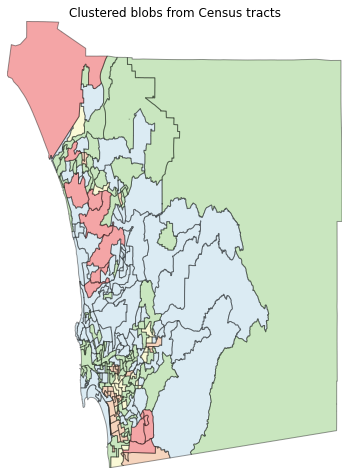

In [57]:
#visualize the blobs after clustering. Blobs within a cluster have same color.
cl.plot_map(blob_shp='blob_test_1.shp')